<a href="https://colab.research.google.com/github/Koel09/DS_Classification_SpeciesDetermination/blob/main/speciesdetermination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score,
    precision_score, recall_score, f1_score, log_loss, roc_auc_score, roc_curve
)
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn import tree
%matplotlib inline

In [8]:
from google.colab import files
uploaded = files.upload()

Saving IRIS.csv to IRIS (1).csv


In [9]:
# Load the dataset
df = pd.read_csv('IRIS.csv')  # Replace with your file path
# Display dataset info
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
df.head()

Dataset Shape: (129, 5)

First 5 Rows:


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [10]:
# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())


Missing Values:
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64


In [11]:
#check number of classes in label
pd.unique(df['species'])

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [12]:
# Preprocessing
# Encode target variable
if df['species'].dtype == 'object':
    le = LabelEncoder()
    df['species'] = le.fit_transform(df['species'])

#check encoded classes
pd.unique(df['species'])

#check for dataset imbalance
print('number of samples in each class:')
df['species'].value_counts()

number of samples in each class:


,count
species,
0,50
1,50
2,29


In [13]:
#balancing dataset
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(df['species']), y=df['species'])
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(df['species']), class_weights)}

# Compute sample weights for each instance
sample_weights = compute_sample_weight(class_weight=class_weights_dict, y=df['species'])

class_weights_dict


{np.int64(0): np.float64(0.86),
 np.int64(1): np.float64(0.86),
 np.int64(2): np.float64(1.4827586206896552)}

In [14]:
# Split features and target
X = df.drop('species', axis=1)
y = df['species']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
# Train-test split
X_train, X_test, y_train, y_test, sw_train, sw_test = train_test_split(X_scaled, y, sample_weights, test_size=0.3, stratify=y, random_state=42)

In [16]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width,species
count,129.000000,129.000000,129.000000,129.000000,129.000000
mean,5.716279,3.057364,3.476744,1.062791,0.837209
std,0.794983,0.453075,1.739231,0.727804,0.768427
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.500000,0.200000,0.000000
50%,5.600000,3.000000,4.000000,1.200000,1.000000
75%,6.300000,3.400000,4.800000,1.600000,1.000000
max,7.700000,4.400000,6.900000,2.500000,2.000000


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129 entries, 0 to 128
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  129 non-null    float64
 1   sepal_width   129 non-null    float64
 2   petal_length  129 non-null    float64
 3   petal_width   129 non-null    float64
 4   species       129 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 5.2 KB


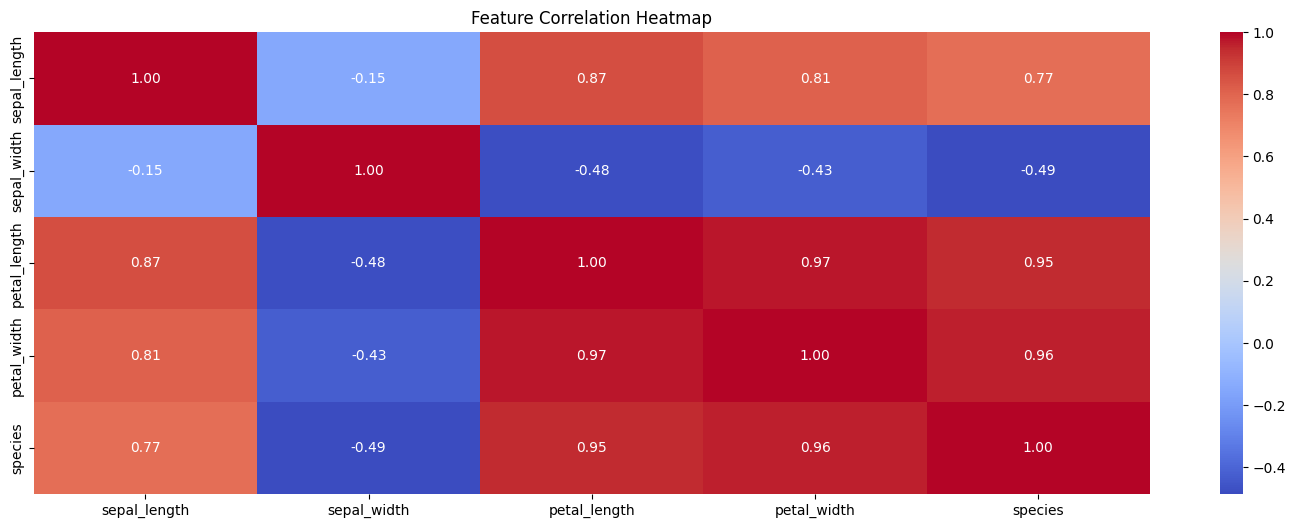

In [18]:
# Correlation heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Heatmap')
plt.show()

<Figure size 1800x600 with 0 Axes>

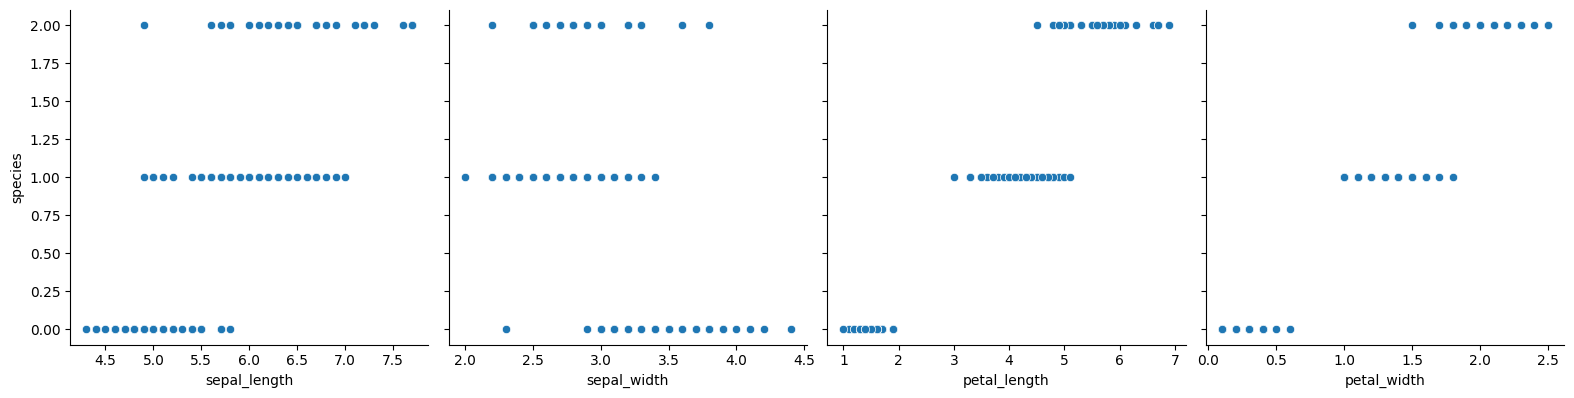

In [19]:
# Boxplot to detect outliers
plt.figure(figsize=(18, 6))
#to plot all the scatterplots in a single plot
sns.pairplot(df, x_vars=['sepal_length','sepal_width','petal_length','petal_width'], y_vars = 'species', height = 4, kind = 'scatter' )
plt.show()

In [20]:


# class 2(Iris- Verginica) size is comparatively bigger than the rest based on petal length and width but it overlaps with class 1
# Class 0(Iris- Setosa) is the smallest among these 3 species and is easily distinguishable than the other 2 classes
# Species is correlated with petal length, petal width and sepal length so petal dimensions are highly effective
# in distinguishing between the different iris species.
# class 0(Iris Setosa)_ pl: 1-2 cm, pw: 0.1-0.6 cm, sl: 4-5.8 cm, sw: 2.9-4.4 cm with one outlier
# class 1(Iris Versicolor)_ pl: 3-5.5 cm, pw: 1-1.9 cm, sl: 4.9-7 cm, sw: 2-3.5 cm
# class 2(Iris Verginica)_ pl: 4.5-7 cm, pw: 1.5-2.5 cm, sl: 5.5-7.7 cm with one outlier , sw: 2.2-3.9 cm
# species with longer and wider petal has longer sepal

In [21]:
from sklearn.metrics import mean_squared_error, r2_score
# Model Evaluation Metrics
def evaluate_model(y_true, y_pred, multi_class, y_proba=None):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    print(f'Mean Squared Error: {mse:.2f}') # Lower the value the better
    print(f'R-squared Score: {r2:.2f}') # Higher the value or closer the value to 1 the better
    if y_proba is not None:
        print("Log Loss:", log_loss(y_true, y_proba))
        print(f"ROC AUC Score ({multi_class}):", roc_auc_score(y_true, y_proba, multi_class=multi_class))

In [22]:
# Multi-Class Classification without dataset balancing
# Logistic Regression (One-vs-Rest)
lr_ovr = OneVsRestClassifier(LogisticRegression())
lr_ovr.fit(X_train, y_train)
y_pred_lr_ovr = lr_ovr.predict(X_test)

# Evaluate Logistic Regression (OvR)
evaluate_model(y_test, y_pred_lr_ovr,'ovr', lr_ovr.predict_proba(X_test))

Confusion Matrix:
[[15  0  0]
 [ 0 13  2]
 [ 0  1  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.93      0.87      0.90        15
           2       0.80      0.89      0.84         9

    accuracy                           0.92        39
   macro avg       0.91      0.92      0.91        39
weighted avg       0.93      0.92      0.92        39

Mean Squared Error: 0.08
R-squared Score: 0.87
Log Loss: 0.31997430412578065
ROC AUC Score (ovr): 0.9817901234567902


In [23]:
# 15 correct classification of class 0
# 13 correct classification of class 1 , 2 incorrectly classified as class 2
# 1 incorrectly classified as class 1 and 8 correctly classified as class 2

In [24]:
# Multi-Class Classification with dataset balancing
from sklearn import set_config
# Enable metadata routing for OneVsRestClassifier
set_config(enable_metadata_routing=True)

# Train model with sample weights using OneVsRestClassifier with Logistic Regression
clf = OneVsRestClassifier(LogisticRegression(class_weight=class_weights_dict, max_iter=10000))
clf.estimator.set_fit_request(sample_weight=True)  # Explicitly request sample_weight
clf.fit(X_train, y_train, sample_weight=sw_train)

y_pred = clf.predict(X_test)

# Evaluate Logistic Regression (OvR)
evaluate_model(y_test, y_pred,'ovr', clf.predict_proba(X_test))

Confusion Matrix:
[[15  0  0]
 [ 0  9  6]
 [ 0  0  9]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.60      0.75        15
           2       0.60      1.00      0.75         9

    accuracy                           0.85        39
   macro avg       0.87      0.87      0.83        39
weighted avg       0.91      0.85      0.85        39

Mean Squared Error: 0.15
R-squared Score: 0.74
Log Loss: 0.37235171643318665
ROC AUC Score (ovr): 0.9706790123456791


In [25]:
# Model is biased towards 2 classes

In [26]:
# Logistic Regression (One-vs-One) without dataset balancing
lr_ovo = OneVsOneClassifier(LogisticRegression())
lr_ovo.fit(X_train, y_train)
y_pred_lr_ovo = lr_ovo.predict(X_test)

# Evaluate Logistic Regression (OvO)
evaluate_model(y_test, y_pred_lr_ovo, 'ovo')

Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  1  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.89      0.94         9

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39

Mean Squared Error: 0.03
R-squared Score: 0.96


In [27]:
# Logistic Regression (One-vs-One) with dataset balancing
lr_ovob = OneVsOneClassifier(LogisticRegression(class_weight=class_weights_dict, max_iter=10000))
lr_ovob.estimator.set_fit_request(sample_weight=True)  # Explicitly request sample_weight
lr_ovob.fit(X_train, y_train, sample_weight=sw_train)
y_pred_lr_ovob = lr_ovob.predict(X_test)

# Evaluate Logistic Regression (OvO)
evaluate_model(y_test, y_pred_lr_ovob, 'ovo')

Confusion Matrix:
[[15  0  0]
 [ 0 14  1]
 [ 0  1  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.93      0.93      0.93        15
           2       0.89      0.89      0.89         9

    accuracy                           0.95        39
   macro avg       0.94      0.94      0.94        39
weighted avg       0.95      0.95      0.95        39

Mean Squared Error: 0.05
R-squared Score: 0.91


In [28]:
# Softmax Regression (Multinomial Logistic Regression) without dataset balancing
softmax = LogisticRegression(solver='lbfgs')
softmax.fit(X_train, y_train)
y_pred_softmax = softmax.predict(X_test)

# Evaluate Softmax Regression
evaluate_model(y_test, y_pred_softmax,'ovr', clf.predict_proba(X_test))

Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  1  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.89      0.94         9

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39

Mean Squared Error: 0.03
R-squared Score: 0.96
Log Loss: 0.37235171643318665
ROC AUC Score (ovr): 0.9706790123456791


In [29]:
# Softmax Regression (Multinomial Logistic Regression) with dataset balancing
softmaxb = LogisticRegression( solver='lbfgs',class_weight=class_weights_dict, max_iter=10000)
softmaxb.fit(X_train, y_train, sample_weight=sw_train)
y_pred_softmaxb = softmaxb.predict(X_test)

# Evaluate Softmax Regression
evaluate_model(y_test, y_pred_softmaxb,'ovr', clf.predict_proba(X_test))

Confusion Matrix:
[[15  0  0]
 [ 0 14  1]
 [ 0  0  9]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      0.93      0.97        15
           2       0.90      1.00      0.95         9

    accuracy                           0.97        39
   macro avg       0.97      0.98      0.97        39
weighted avg       0.98      0.97      0.97        39

Mean Squared Error: 0.03
R-squared Score: 0.96
Log Loss: 0.37235171643318665
ROC AUC Score (ovr): 0.9706790123456791


In [30]:
# Decision Tree without dataset balancing
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("\nDecision Tree Performance:")
evaluate_model(y_test, y_pred_dt,'ovr', dt.predict_proba(X_test))


Decision Tree Performance:
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  1  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.89      0.94         9

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39

Mean Squared Error: 0.03
R-squared Score: 0.96
Log Loss: 0.9241962407465939
ROC AUC Score (ovr): 0.9745370370370371


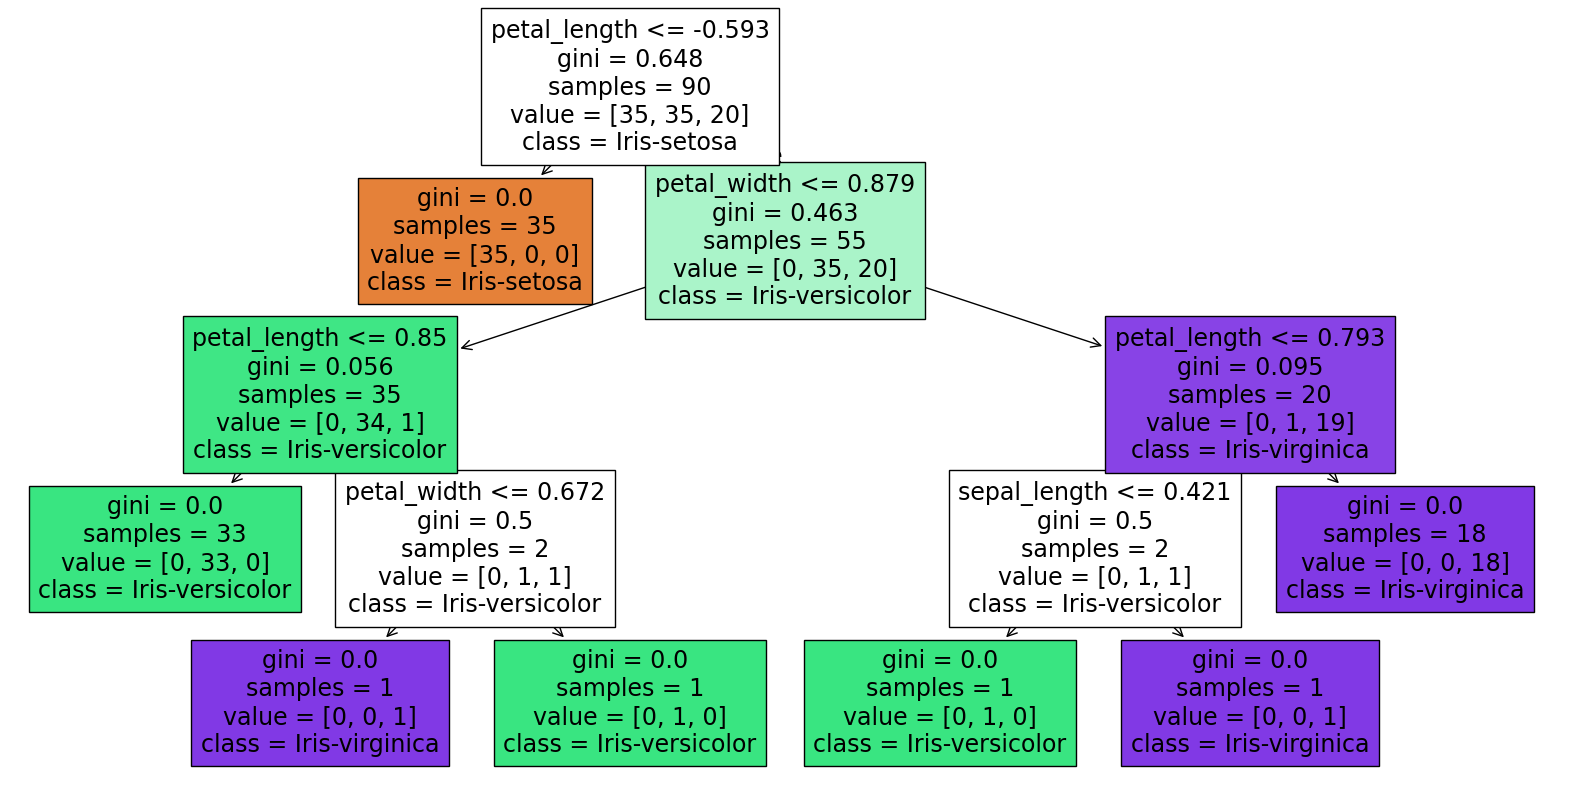

In [31]:
# Visualize Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True, feature_names=X.columns, class_names=le.classes_)
plt.show()

In [32]:
# Decision Tree with dataset balancing
dtb = DecisionTreeClassifier(random_state=42,class_weight=class_weights_dict)
# dtb.estimator.set_fit_request(sample_weight=True)  # Explicitly request sample_weight
dtb.fit(X_train, y_train, sample_weight=sw_train)
y_pred_dtb = dtb.predict(X_test)

print("\nDecision Tree Performance:")
evaluate_model(y_test, y_pred_dtb,'ovr', dtb.predict_proba(X_test))


Decision Tree Performance:
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  1  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.89      0.94         9

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39

Mean Squared Error: 0.03
R-squared Score: 0.96
Log Loss: 0.9241962407465939
ROC AUC Score (ovr): 0.9745370370370371


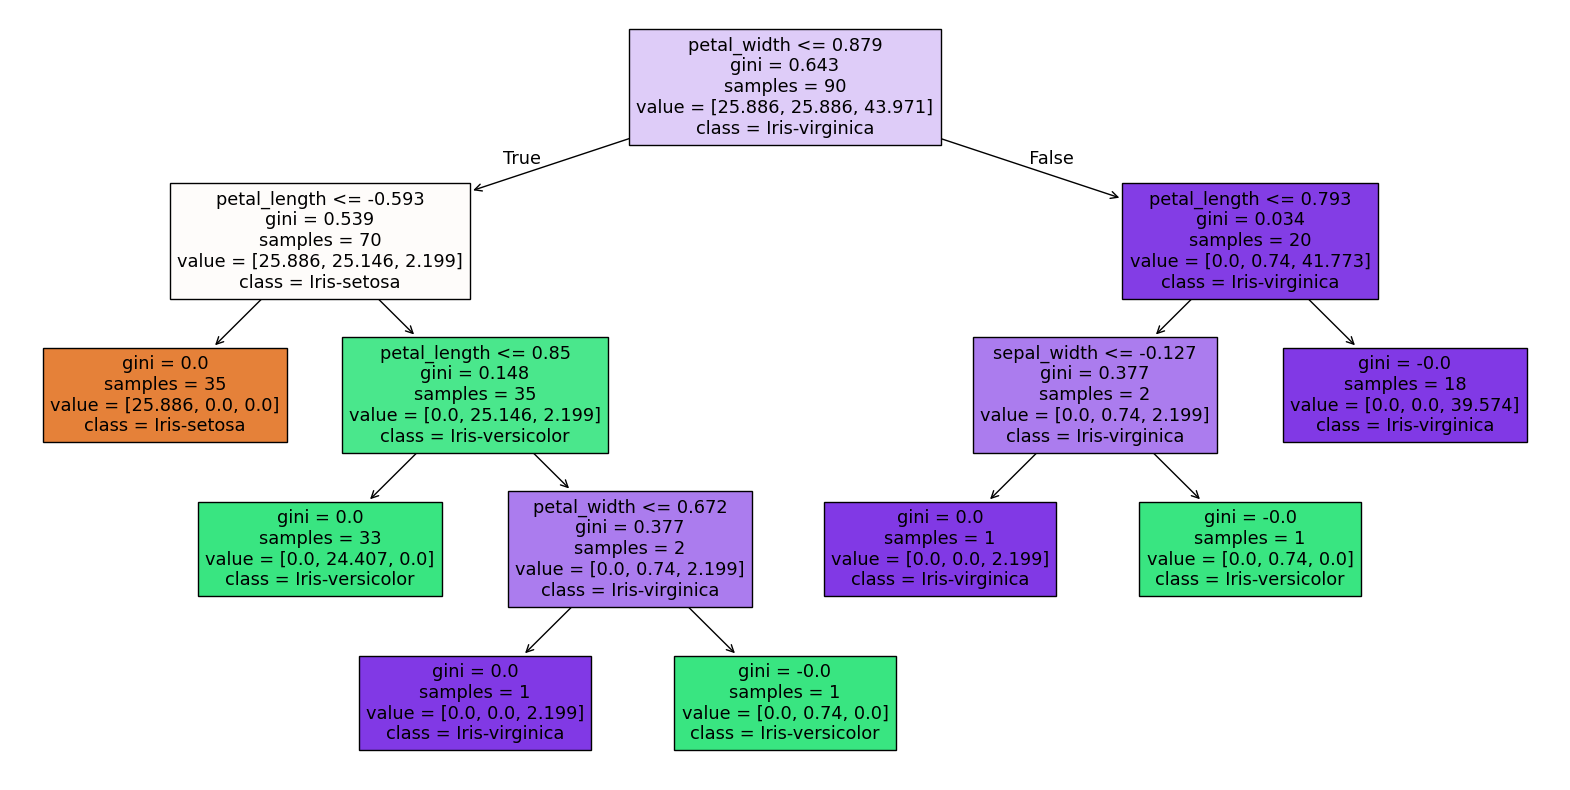

In [33]:
# Visualize Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dtb, filled=True, feature_names=X.columns, class_names=le.classes_)
plt.show()

In [34]:
# Hyperparameter Tuning (Decision Tree)
param_grid = {
    'max_depth': [3, 5, 7, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train, y_train)

print("\nBest Parameters for Decision Tree:")
print(grid_search.best_params_)


Best Parameters for Decision Tree:
{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [35]:
# Evaluate tuned Decision Tree
best_dt = grid_search.best_estimator_
y_pred_best_dt = best_dt.predict(X_test)

print("\nTuned Decision Tree Performance:")
evaluate_model(y_test, y_pred_best_dt,'ovr', best_dt.predict_proba(X_test))


Tuned Decision Tree Performance:
Confusion Matrix:
[[15  0  0]
 [ 0 15  0]
 [ 0  1  8]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       0.94      1.00      0.97        15
           2       1.00      0.89      0.94         9

    accuracy                           0.97        39
   macro avg       0.98      0.96      0.97        39
weighted avg       0.98      0.97      0.97        39

Mean Squared Error: 0.03
R-squared Score: 0.96
Log Loss: 0.9419692453763361
ROC AUC Score (ovr): 0.9734567901234569


In [36]:
# Model Comparison
models = {
    'Logistic Regression (OvR)': lr_ovr,
    'Logistic Regression (OvR) with balanced dataset': clf,
    'Logistic Regression (OvO)': lr_ovo,
    'Logistic Regression (OvO) with balanced dataset': lr_ovob,
    'Softmax Regression': softmax,
    'Softmax Regression with balanced dataset': softmaxb,
    'Decision Tree': dt,
    'Decision Tree with balanced dataset': dtb
}

metrics = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    # Check if the model is OneVsOneClassifier
    if name == 'Logistic Regression (OvO)' or name == 'Logistic Regression (OvO) with balanced dataset':
        # OneVsOneClassifier does not support predict_proba
        metrics.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1': f1_score(y_test, y_pred, average='weighted'),
            'Log Loss': 'Not Available',
            'ROC AUC (OvR)': 'Not Available'
        })
    else:
        # For other models, calculate predict_proba
        y_proba = model.predict_proba(X_test)
        metrics.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1': f1_score(y_test, y_pred, average='weighted'),
            'Log Loss': log_loss(y_test, y_proba),
            'ROC AUC (OvR)': roc_auc_score(y_test, y_proba, multi_class='ovr')
        })

metrics_df = pd.DataFrame(metrics)
print("\nModel Comparison:")
metrics_df


Model Comparison:


,Model,Accuracy,Precision,Recall,F1,Log Loss,ROC AUC (OvR)
0,Logistic Regression (OvR),0.923077,0.926374,0.923077,0.923775,0.319974,0.98179
1,Logistic Regression (OvR) with balanced dataset,0.846154,0.907692,0.846154,0.846154,0.372352,0.970679
2,Logistic Regression (OvO),0.974359,0.975962,0.974359,0.974018,Not Available,Not Available
3,Logistic Regression (OvO) with balanced dataset,0.948718,0.948718,0.948718,0.948718,Not Available,Not Available
4,Softmax Regression,0.974359,0.975962,0.974359,0.974018,0.15615,1.0
5,Softmax Regression with balanced dataset,0.974359,0.976923,0.974359,0.974592,0.181748,1.0
6,Decision Tree,0.974359,0.975962,0.974359,0.974018,0.924196,0.974537
7,Decision Tree with balanced dataset,0.974359,0.975962,0.974359,0.974018,0.924196,0.974537


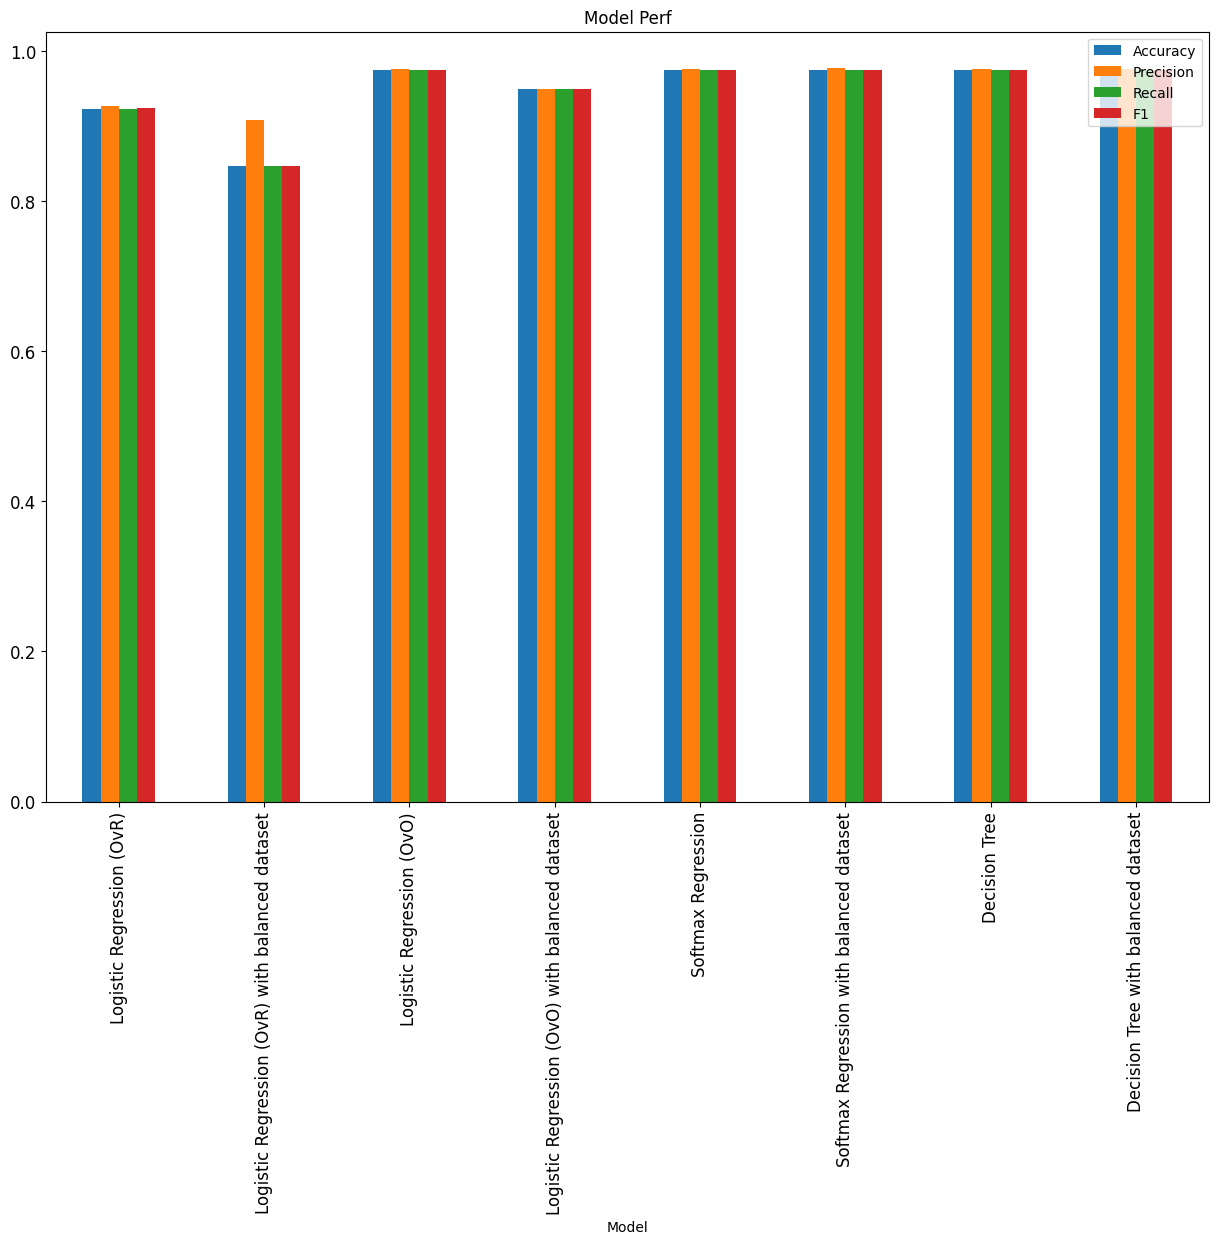

In [37]:
metrics_bar = metrics_df.plot(x='Model', y= ['Accuracy','Precision','Recall','F1'],kind='bar', title ="Model Perf",
                              figsize=(15, 10),xlabel='Model', legend=True, fontsize=12)
plt.show()